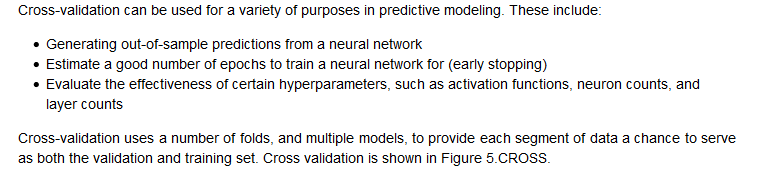

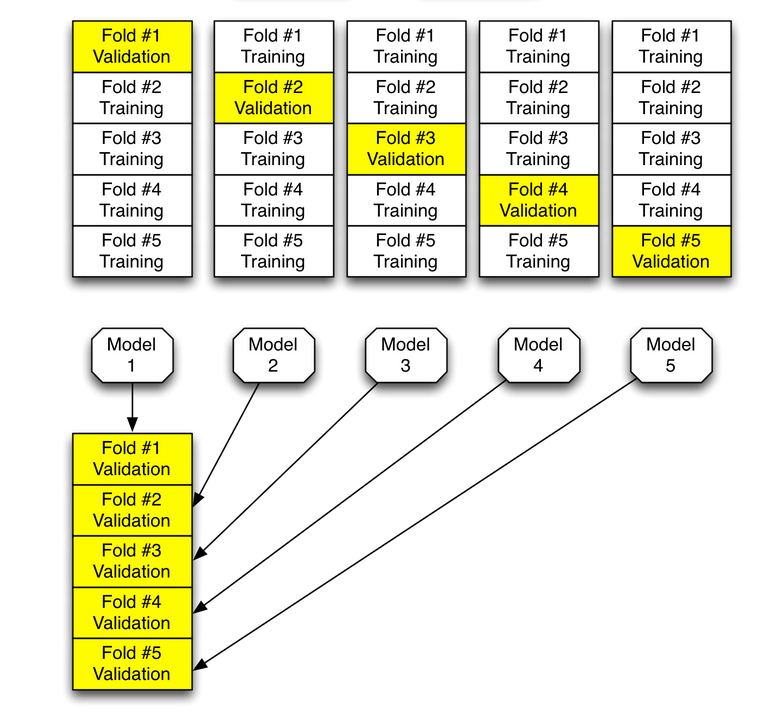

# k-fold cross validation for regression

In [41]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

In [42]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42) # Use for KFold classification
    
oos_y = []
oos_pred = []

fold = 0
for train, test in kf.split(x):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,
              epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)    

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print(f"Fold score (RMSE): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print(f"Final, out of sample score (RMSE): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
#oosDF.to_csv(filename_write,index=False)

Fold #1
Fold score (RMSE): 0.5152663089799223
Fold #2
Fold score (RMSE): 0.5737325887847519
Fold #3
Fold score (RMSE): 0.6480635826890457
Fold #4
Fold score (RMSE): 0.5535915321726711
Fold #5
Fold score (RMSE): 1.0114076597607684
Final, out of sample score (RMSE): 0.6846990431608981


# Classification with Stratified K-Fold Cross-Validation 

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# np.argmax(pred,axis=1)
# Cross-validate
# Use for StratifiedKFold classification
kf = StratifiedKFold(5, shuffle=True, random_state=42) 
    
oos_y = []
oos_pred = []
fold = 0

# Must specify y StratifiedKFold for
for train, test in kf.split(x,df['product']):  
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    # raw probabilities to chosen class (highest probability)
    pred = np.argmax(pred,axis=1) 
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
#oosDF.to_csv(filename_write,index=False)

# WITH HOLDOUT

In [ ]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 


# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(x_main):        
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),
              verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred) 

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print(f"Fold score (RMSE): {score}")


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print()
print(f"Cross-validated score (RMSE): {score}")    
    
# Write the cross-validated prediction (from the last neural network)
holdout_pred = model.predict(x_holdout)

score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print(f"Holdout score (RMSE): {score}")